In [309]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
import warnings
from time import time

from astropy.table import Table, Column, vstack

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Visualize the student-T distribution as prior for the slope of the scaling relation

In [124]:
from prospect.models import priors

from scipy.stats import uniform
from scipy.stats import t as student_t

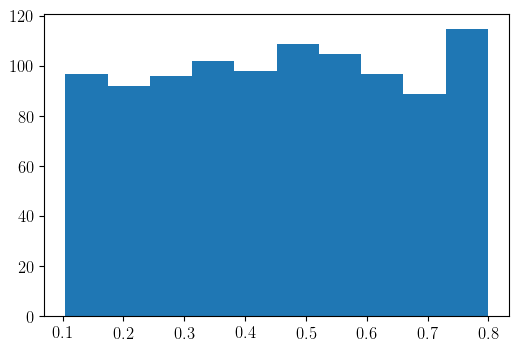

In [175]:
from asap import priors

flat = priors.TopHat(low=0.1, upp=0.8)

_ = plt.hist(flat.sample(nsample=1000))

In [126]:
flat.inverse_unit_transform(0.1)

0.0

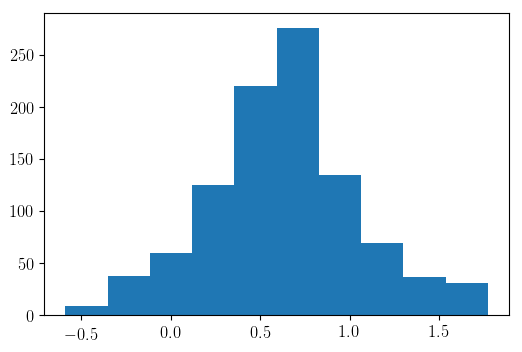

In [176]:
student = priors.StudentT(loc=0.6, scale=0.3, df=1)

_ = plt.hist(student.sample(nsample=1000, limit=True))

In [289]:
from asap import priors, parameters

# Parameters are described by a dictionary, which can be loaded from `yaml` configuration file.
# The format of the config for parameter is:

"""
parameter_1:
    name : 'a'
    label : 'a'
    type : 'flat'
    ini : 0.0
    sig : 1.0
    min : -1.0
    max : 1.0
"""

# For example, here are two parameters
#    a : flat distribution between 0.0 and 1.0; use the min and max parameters
#    b : 1-D student T-distribution with mean = 1.0, nu = 0.5; use the ini and sig parameters
param_a = {'name': 'a', 'type': 'flat', 'min': 0.0, 'max': 1.0}
param_b = {'name': 'b', 'type': 'student', 'ini': 1.0, 'sig': 0.5}
param_dict = {'param_1': param_a, 'param_2': param_b}

param = parameters.AsapParams(param_dict)

# If you want to use the mean of each distribution to initiate the sample
print(param.ini)

# If you want to get the lower and upper boundaries of the distributinos.
# For Student-T, using mean +/- 4 * nu
print(param.low, param.upp)

# The "distr" property gives you a list of prior distributions defined in priors.py
print(param.distr)

# If you want to generate a random set of parameters
print(param.sample())

# If you want to populate the emcee walkers using the prior distributions
# e.g. N_walker = 100; the output is in (N_walker, N_param) shape.
print(param.sample(nsamples=100).shape)

# If you want to populate the emcee walkers using small perturbations around the mean 
# of each distribution 
# e.g. 10 walkers, 10% level perturbation
print(param.perturb(nsample=10, level=0.1))

# If you have a set of parameters, and need the sum of log(Prior) probabilities
theta = [0.5, 0.5]
print(param.lnprior(theta))

# It will return -np.inf when the parameter is out of bounds
theta = [1.2, 0.5]
print(param.lnprior(theta))

[0.5 1. ]
[ 0. -1.] [1. 3.]
[<asap.priors.TopHat object at 0x169f74080>, <asap.priors.StudentT object at 0x169f74a90>]
[[0.03558836 0.50710278]]
(100, 2)
[[0.65422401 0.84743317]
 [0.50455991 0.88369361]
 [0.41102608 1.26310917]
 [0.4839083  0.96745281]
 [0.60968016 1.13684102]
 [0.56399299 0.69378113]
 [0.43557554 1.13588799]
 [0.44812913 0.70116876]
 [0.29788239 0.89502531]
 [0.43747993 0.78462898]]
-1.1447298858494
-inf


### Test: configuration file

In [310]:
from asap import io
from asap import config

config_file = '/Users/song/Dropbox/work/project/asap/asap/default_config.yaml'

In [311]:
from asap.parameters import AsapParams

params = AsapParams(cfg_param)

print(params.lnprior([0.2, 3.0, 0.05, 0.1, 0.6, -0.1, 0.2]))

print(params.transform([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))

1.5641465809610384
[ 6.00000000e-01  3.50000000e+00  4.08878139e-18  1.00000000e-01
  6.50000000e-01 -2.00000000e-01  2.50000000e-01]


In [312]:
from asap import fitting

cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

# Running model: asap_mmax_m10_frac4_test_A
#    Will use emcee as sampler ...
#    Use   128 walkers with    stretch moves for   100 steps of burn-in
#    Use   400 walkers with        kde moves for   100 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_massive_boxbin7_default_dsigma_results.pkl
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_0.7124_new_vagc_mpeak_11.5.npy
# DSigma results : um_smdpl_0.7124_new_vagc_mpeak_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total stellar m

In [314]:
obs_data['wl_bin']

bin_id,min_logm_1,max_logm_1,min_logm_2,max_logm_2,n_gal
int64,float64,float64,float64,float64,int64
1,11.600151491155703,11.692986502149385,10.894132861645366,11.279281317732739,559
2,11.600111114967284,11.693179957110186,11.27947751766791,11.34235868168652,559
3,11.600075995764213,11.69324885107798,11.342473530681904,11.580828883820999,558
4,11.693384906904946,11.786393284048767,10.961286916417574,11.335788209248166,288
5,11.693934050535818,11.786314823179838,11.33587223445542,11.395767744233344,288
6,11.693644425784651,11.786309289274852,11.396242714951454,11.560091892749517,286
7,11.786965093487783,11.877999748357684,11.033718451476588,11.37597591351112,131
8,11.786788813734335,11.877812535160476,11.37703312293129,11.446836720900821,131
9,11.78882197729743,11.878763414813388,11.447028360504143,11.595663247101403,131


In [317]:
obs_data['wl_dsigma'][0].r

array([0.18154998, 0.26595373, 0.38959733, 0.57072364, 0.83605672,
       1.22474487, 1.79413664, 2.6282423 , 3.85012905, 5.6400788 ,
       8.2621877 ])